<a href="https://colab.research.google.com/github/atharvakale31/DL_auto_encoders/blob/master/VQ_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt

import glob
import cv2
from sklearn.model_selection import train_test_split

print(tf.__version__)
print(K.__version__)

2.6.0
2.6.0


In [2]:
dataset_url = "http://aisdatasets.informatik.uni-freiburg.de/freiburg_groceries_dataset/freiburg_groceries_dataset.tar.gz"
data_dir = tf.keras.utils.get_file('images', origin=dataset_url,  cache_dir='.', untar=True)

541573120/541562880 [==============================] - 21s 0us/step


In [3]:
# img_list = sorted(glob.glob('/content/dog/*.jpg'))
img_list = sorted(glob.glob('/content/datasets/images/*/*.png'))

In [4]:
IMG_SIZE = 128
IMG_HEIGHT=128
IMG_WIDTH = 128
img_data_array=[]
# x_data = np.empty((len(img_list), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
for i, img_path in enumerate(img_list):

  image= cv2.imread( img_path)
  image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image=np.array(image)
  image = image.astype('float32')
  image /= 255 
  img_data_array.append(image)


In [5]:
img_data=np.array(img_data_array, np.float32)

In [6]:
len(img_list)

4947

In [7]:
del img_data_array

In [8]:
train_images, test_images,_, _ = train_test_split(img_data, img_data, test_size=0.05, random_state=42)

In [9]:
train_images=train_images.reshape((train_images.shape[0],train_images.shape[1], train_images.shape[2], 3))
test_images=test_images.reshape((test_images.shape[0],test_images.shape[1], test_images.shape[2], 3))

In [10]:
print(train_images.shape)
print(test_images.shape)

(4699, 128, 128, 3)
(248, 128, 128, 3)


In [11]:
del img_data

In [12]:
x_train=train_images
x_test=test_images
print("Train images:", x_train.shape)  #Train images: (60000, 28,28,1)
# print("Train labels:", y_train.shape)     # Train labels: (60000,)
print("Test images:", x_test.shape)    # Test images: (10000, 28, 28)
# print("Test labels:", y_test.shape)     # Test labels: (10000,)
# print(y_train.dtype)
# print("Train labels:", y_train.shape)
print(x_test[0].shape)   # (28,28,1) input image
print(x_train.shape[0])   # 60000 no of input images

Train images: (4699, 128, 128, 3)
Test images: (248, 128, 128, 3)
(128, 128, 3)
4699


In [ ]:
l=np.load("/content/fashion_mnist.npz")

In [ ]:
l.files

['Y_train', 'Y_test', 'X_test', 'X_train']

In [ ]:
print(tf.norm(np.array([[1.,2.],[3.,4.]])-np.array([[1.,2.],[3.,4.]]),axis=0))

tf.Tensor([0. 0.], shape=(2,), dtype=float64)


In [ ]:
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['X_train'], f['Y_train']
        x_train=np.reshape(x_train,(-2,28,28))
        
        x_test, y_test = f['X_test'], f['Y_test']
        x_test=np.reshape(x_test,(-2,28,28))# (60000,784,1)
        return (x_train[..., None] / 255., y_train), (x_test[..., None] / 255., y_test)


(x_train, y_train), (x_test, y_test) =load_data("/content/fashion_mnist.npz")
#K.datasets.mnist.load_data(    # K = tf.keras
 # path='mnist.npz')
# load_data('mnist.npz')
#x_train = tf.expand_dims(x_train,-1)
#x_test = tf.expand_dims(x_test,-1)
print("Train images:", x_train.shape)  #Train images: (60000, 28,28,1)
print("Train labels:", y_train.shape)     # Train labels: (60000,)
print("Test images:", x_test.shape)    # Test images: (10000, 28, 28)
print("Test labels:", y_test.shape)     # Test labels: (10000,)
print(y_train.dtype)
print("Train labels:", y_train.shape)
print(x_test[0].shape)   # (28,28,1) input image
print(x_train.shape[0])   # 60000 no of input images

Train images: (60000, 28, 28, 1)
Train labels: (60000, 10)
Test images: (10000, 28, 28, 1)
Test labels: (10000, 10)
float64
Train labels: (60000, 10)
(28, 28, 1)
60000


In [14]:
NUM_LATENT_K = 512                 # Number of codebook entries
NUM_LATENT_D = 64   # Dimension of each codebook entry
BETA = 1.0                        # Weight for the commitment loss

INPUT_SHAPE = x_train.shape[1:]
print(INPUT_SHAPE)    # (28,28,1)


SIZE = None                       # Spatial size of latent embedding
                                  # will be set dynamically in `build_vqvae


VQVAE_BATCH_SIZE = 32           # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 20             # Number of epochs
VQVAE_LEARNING_RATE = 3e-4        # Learning rate
VQVAE_LAYERS = [256, 256]           # Number of filters for each layer in the encoder



PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block

(128, 128, 3)


In [15]:
class VectorQuantizer(K.layers.Layer):  
    def __init__(self, k, **kwargs):              #  this is the CONSTRUCTOR
        super(VectorQuantizer, self).__init__(**kwargs)   # super class CONSTRUCTOR is called with this line.
        self.k = k                                # k is a value that will be passed to the object of the CLASS that will be created

    def build(self, input_shape):         # this function inititlaizes the CODEBOOK entries  with Random values from a UNIFORM distribution
        self.d = int(input_shape[-1])    # d is the last dimension off the Input shape.
        rand_init = K.initializers.VarianceScaling(distribution="uniform")   # VarianceScaling allows the variance to VARY during training
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True) # https://www.kite.com/python/docs/tensorflow.keras.Model.add_weight

    def call(self, inputs):         # Map z_e of shape (b, w, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d)) #(1,1,1,k,d)
        z_e = tf.expand_dims(inputs, -2)                                     #(b,w,1,h,d) 
        dist = tf.norm(z_e - lookup_, axis=-1) #() # tf.norm in TENSORFLOW gives the EUCLIEDIAN distance i.e. L2 NORM
        k_index = tf.argmin(dist, axis=-1)
        return k_index #index wise encoded 
           
    def sample(self, k_index):        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d)) #(1,1,1,k,d)
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        print(z_q.shape) #(None,7,7,64)
        return z_q              # z_q are the quantized codes
    

In [16]:
def encoder_pass(inputs, d, num_layers=[256, 256] ):
    x = inputs 
    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='relu', 
                            strides=(2, 2), name="conv{}".format(i + 1))(x)
    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
                          strides=(1, 1), name='z_e')(x)
    return z_e #(,7,7,64)

In [17]:
def decoder_pass(inputs, num_layers=[256, 256] ):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(2, 2), padding="SAME", 
                                     activation='relu', name="convT{}".format(i + 1))(y)
    decoded = K.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=(1, 1), 
                                       padding="SAME", activation='sigmoid', name='output')(y)
    return decoded

In [18]:
def build_vqvae(k, d, input_shape=(128,128,3), num_layers=[256, 256] ):
    global SIZE
    
    ## Encoder
    encoder_inputs = K.layers.Input(shape=(input_shape), name='encoder_inputs')
    print(encoder_inputs.shape)
    #encoder_inputs=tf.expand_dims(encoder_inputs,-1)
    #print(encoder_inputs.shape)
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    print(z_e.shape[1])
    SIZE = int(z_e.get_shape()[1]) #7

 ## Vector Quantization
    vector_quantizer = VectorQuantizer(k, name='vector_quantizer')
    codebook_indices = vector_quantizer(z_e) # goes to build (assumed)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')   # Model number 01

## Decoder
    decoder_inputs = K.layers.Input(shape=(SIZE, SIZE, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])    # takes 32 first and then 16 filters. since this is the decoder
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')     # Model number 02

## VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")# x could be codebook_indices
    z_q = sampling_layer(codebook_indices) #codebook_indices == k_index
    codes = tf.stack([z_e, z_q], axis=-1) #????
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
                       # z_e + sg(z_q-z_e) ?????
    straight_through_zq = straight_through([z_q, z_e]) #opp order
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')#model no.3

 ## VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZE, SIZE), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices) #(7,7,64)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler') #model no.4

 ## Transition from codebook indices to model (for training the prior later) ?????
    indices = K.layers.Input(shape=(SIZE, SIZE), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler") #model no.5

    ## Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook') #model no.6
    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook
    
    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook  

vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook = build_vqvae(
    NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)

vq_vae.summary() 

(None, 128, 128, 3)
32
(None, 32, 32, 64)
The following Variables were used a Lambda layer's call (sample_from_codebook), but
are not present in its tracked objects:
  <tf.Variable 'vector_quantizer/Variable:0' shape=(512, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
(None, 32, 32, 64)
(None, 32, 32, 64)
(None, 1, 1, 64)
Model: "vq-vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 256)  7168        encoder_inputs[0][0]         

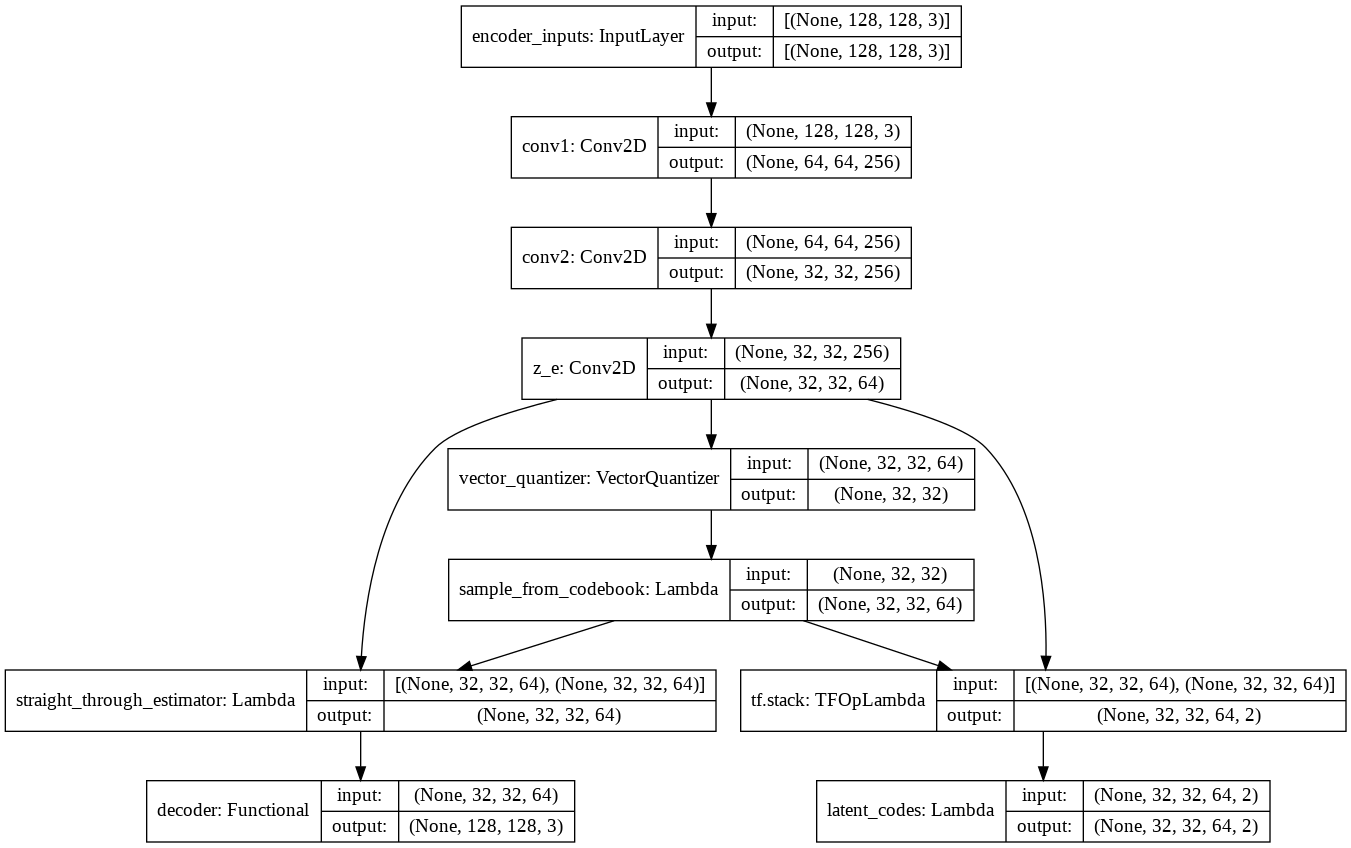

In [19]:
tf.keras.utils.plot_model(vq_vae,show_shapes=True)

In [20]:
def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)   
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss 

In [21]:
def zq_norm(y_true, y_pred):   # This is a metric that calculates how often prediction equals labels
    del y_true                       # TF syntax REQUIRES y_true and y_pred
    _, z_q = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_q, axis=-1))

def ze_norm(y_true, y_pred):  # This is a metric that calculates how often prediction equals labels
    del y_true
    z_e, _ = tf.split(y_pred, 2, axis=-1)
    return tf.reduce_mean(tf.norm(z_e, axis=-1))

In [22]:
## Compile and train
# ab=np.full((60000,28,28,1),0)
ab=np.full((4699,128,128,3),0)
#ab=tf.cast(ab,tf.float32)
print(ab.dtype)
vq_vae.compile(loss=[mse_loss, latent_loss], metrics={"latent_codes": [zq_norm, ze_norm]}, optimizer= K.optimizers.Adam(VQVAE_LEARNING_RATE))
#x_train=tf.cast(x_train,tf.float32)


int64


In [23]:
history=vq_vae.fit(x_train, [x_train,ab], epochs=10, batch_size=VQVAE_BATCH_SIZE, verbose=2)

Epoch 1/10
(None, 32, 32, 64)
(None, 32, 32, 64)
147/147 - 239s - loss: 0.0580 - decoder_loss: 0.0338 - latent_codes_loss: 0.0242 - latent_codes_zq_norm: 0.0374 - latent_codes_ze_norm: 0.0866
Epoch 2/10
147/147 - 199s - loss: 0.0251 - decoder_loss: 0.0137 - latent_codes_loss: 0.0115 - latent_codes_zq_norm: 0.0498 - latent_codes_ze_norm: 0.0844
Epoch 3/10
147/147 - 199s - loss: 0.0162 - decoder_loss: 0.0107 - latent_codes_loss: 0.0055 - latent_codes_zq_norm: 0.0595 - latent_codes_ze_norm: 0.0785
Epoch 4/10
147/147 - 199s - loss: 0.0140 - decoder_loss: 0.0091 - latent_codes_loss: 0.0049 - latent_codes_zq_norm: 0.0729 - latent_codes_ze_norm: 0.0866
Epoch 5/10
147/147 - 199s - loss: 0.0127 - decoder_loss: 0.0080 - latent_codes_loss: 0.0046 - latent_codes_zq_norm: 0.0867 - latent_codes_ze_norm: 0.0971
Epoch 6/10
147/147 - 199s - loss: 0.0114 - decoder_loss: 0.0072 - latent_codes_loss: 0.0041 - latent_codes_zq_norm: 0.0918 - latent_codes_ze_norm: 0.1006
Epoch 7/10
147/147 - 199s - loss: 0.01

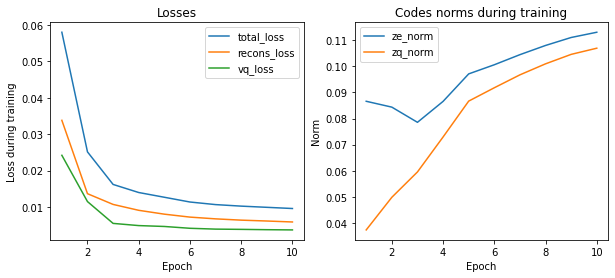

In [24]:
num_epochs = range(1, len(history.history["loss"]) + 1)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(num_epochs, history.history["loss"], label="total_loss")
plt.plot(num_epochs, history.history["decoder_loss"], label="recons_loss")
plt.plot(num_epochs, history.history["latent_codes_loss"], label="vq_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss during training")
plt.legend()
plt.title("Losses")
plt.subplot(1, 2, 2)
plt.plot(num_epochs, history.history["latent_codes_ze_norm"], label="ze_norm")
plt.plot(num_epochs, history.history["latent_codes_zq_norm"], label="zq_norm")
plt.xlabel("Epoch")
plt.ylabel("Norm")
plt.title("Codes norms during training")
plt.legend()
plt.show()

Originals versus reconstructions
(None, 32, 32, 64)
(4, 128, 128, 3)


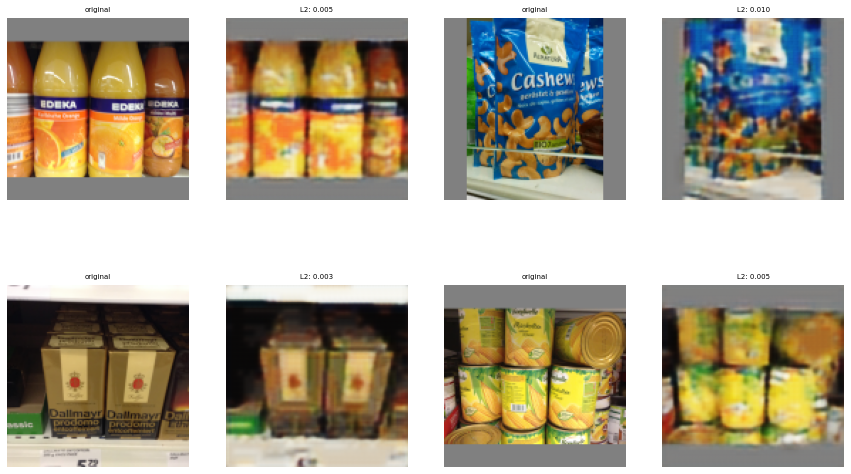

In [25]:
# original versus reconstructions
def recons(model, images, n_row, n_col, random=True):
    n = n_row * n_col
    if random:
        x = np.random.choice(images.shape[0], size=n, replace=False)
        x = images[x]
    else:
        x = images[:n]
    recons, _ = model.predict(x)
    print(recons.shape)
    dists = np.mean((recons - x)**2, axis=(1, 2, 3))
    plt.figure(figsize=(15, 9))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x[i], cmap='gray')
        plt.title("original", fontsize=7)
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(recons[i], cmap='gray')
        plt.title("L2: {:.3f}".format(dists[i]), fontsize=7)
        plt.axis('off')
    plt.show()
    
print("Originals versus reconstructions")
recons(vq_vae, x_test, 2, 2)

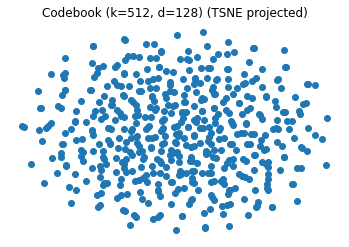

In [ ]:
from sklearn.manifold import TSNE
codebook = get_vq_vae_codebook()
codebook = TSNE(2).fit_transform(codebook)
plt.title("Codebook (k={}, d={}) (TSNE projected)".format(NUM_LATENT_K, NUM_LATENT_D))
plt.scatter(codebook[:, 0], codebook[:, 1])
plt.axis('off')
plt.show()

(None, 32, 32, 128)


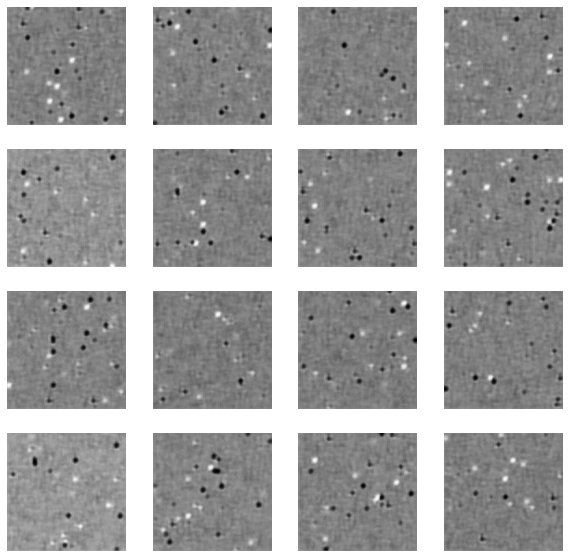

In [ ]:
def generate_from_random(sampler, k, size, n_row, n_col):
    n = n_col * n_row
    indices = np.random.randint(0, k, size=(n, size, size))
    generated = sampler.predict(indices, steps=1)
    plt.figure(figsize=(10, 10))
    for i in range(n):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(generated[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()
    
print("Images generated under a uniform prior (training assumption)")
generate_from_random(vq_vae_sampler, NUM_LATENT_K, SIZE, 4, 4)